# Step 10.1: Understand Model Impacts

## Objective

In this step of the project we are trying to evaluate how the proposed model will impact business decisions. Unlike the final model where we train on the whole dataset, we will still holdout some observations to check how the model will perform on unseen data.

## Findings

we were able to obtain a recall of 0.821 on the test set, which clears the client's requirement.

Unfortunately, we were not able to succeed on the second requirement - precision should not vary by more than 5 percentage points across all protected classes. We observed higher precision for tuples with higher representation (male individuals), and the lowest precisions for underrepresented classes (Female genders and Other ethnicities).

In [23]:
import aux_functions
from app_functions import attempt_predict
from transformers import TimeTransformer2, BoolTransformer, lat_lon_imputer, Group_Age_Range, Group_Ethnicity

import json
import joblib
import pickle
import requests
from time import sleep
import random

import pandas as pd
pd.set_option('display.max_columns', 100)
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import numpy as np
import datetime as dt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import cross_val_score
# from category_encoders import OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder, RobustScaler, OrdinalEncoder
from category_encoders.target_encoder import TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.utils import resample
from sklearn.metrics import precision_score, recall_score, f1_score,  accuracy_score, roc_auc_score, make_scorer, confusion_matrix, roc_curve

# needed to use matplotlib inside jupyter notebook
%matplotlib inline 

# Get the Data

In [24]:
df_ = pd.read_csv("data/train.csv")

drop_cols = ['Self-defined ethnicity', 'Outcome', 'Outcome linked to object of search', 'Removal of more than just outer clothing']

df_clean = aux_functions.clean_data(df_, drop_cols)

df_train, df_test = train_test_split(df_clean, test_size=0.3, random_state=42)

df_test.head()

,observation_id,Type,Date,Part of a policing operation,Latitude,Longitude,Gender,Age range,Officer-defined ethnicity,Legislation,Object of search,station,target
537261,7178a97c-4228-4d89-bbb8-f957b7888823,Person search,2021-08-21T04:20:00+00:00,False,NaN,NaN,Male,25-34,White,Police and Criminal Evidence Act 1984 (section 1),Offensive weapons,south-yorkshire,0
696508,2fa0c965-c196-4a2a-bfa3-645b359ca46f,Person search,2020-05-25T17:12:00+00:00,<NA>,50.811679,-1.083062,Male,10-17,Black,Police and Criminal Evidence Act 1984 (section 1),Offensive weapons,hampshire,0
109550,4621404c-8b8d-4167-93ea-78a2d95d8195,Person search,2021-02-05T19:22:00+00:00,False,NaN,NaN,Male,18-24,Asian,Misuse of Drugs Act 1971 (section 23),Controlled drugs,devon-and-cornwall,1
609848,2b2f6f9d-651e-4d3c-a3a7-a2bc91e721eb,Person search,2020-07-26T13:00:00+00:00,<NA>,53.182283,-3.423552,Male,25-34,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,north-wales,0
247836,af52a1fc-66ab-4225-95b3-6f31d236f687,Person search,2020-09-10T23:00:00+00:00,False,50.875152,0.011468,Male,18-24,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,sussex,0


# Pipeline Definition

In [25]:
def create_pipeline(df, model):

    y = df["target"].copy()
    X = df.drop(columns=["target"]).copy()


    time_cols = ['Date']

    categorical_cols = ['Type', 'Object of search']
    
    bool_cols = ['Part of a policing operation']

    numerical_cols = ['Latitude', 'Longitude', 'station'] # station is needed for NaN imputing

    # Define timeseries pipeline
    time_pipe = Pipeline([
            ('time_transformer', TimeTransformer2()),
            ('scaler', MinMaxScaler())
        ])
    
    
    # Define categorical pipeline
    cat_pipe = Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', TargetEncoder(handle_unknown='value', min_samples_leaf=20 , smoothing=10))
        ])
    
    # Define boolean pipeline
    bool_pipe = Pipeline([
            ('bool_transformer', BoolTransformer())
        ])

    # Define numerical pipeline
    numeric_pipe = Pipeline([
            ('imputer', lat_lon_imputer()),
            ('scaler', MinMaxScaler())
        ])

    
    # Combine categorical and numerical pipelines
    preprocessor = ColumnTransformer([
        ('time_transformer', time_pipe, time_cols),
        ('cat', cat_pipe, categorical_cols),
        ('bool', bool_pipe, bool_cols),
        ('num', numeric_pipe, numerical_cols)
        ],
    remainder='drop')


    # Fit a pipeline with transformers and an estimator to the training data
    pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('model', model)
        ])

    rus = RandomUnderSampler(random_state=42)
    X_resampled, y_resampled = rus.fit_resample(X, y)

    pipeline.fit(X_resampled, np.ravel(y_resampled))
    # pipeline.fit(X, np.ravel(y))


    return pipeline, X_resampled, y_resampled
    # return pipeline, X, y


def see_cross_val(pipeline, X, y):

    prec_scorer = make_scorer(precision_score)

    prec_scores = cross_val_score(pipeline, X, np.ravel(y), cv=5, scoring=prec_scorer)
    print(prec_scores)

# Train Model

In [26]:
# Check transformed data

model = GaussianNB()

pipeline, X_train, y_train = create_pipeline(df_train, model)

columns = ['quarter', 'year', 'hour', 'day of the week', 'Type', 'Object of search', 'Part of a policing operation', 'Latitude', 'Longitude']

# columns = ['quarter', 'year', 'hour', 'day of the week', 'Type', 'Object of search', 'Part of a policing operation']

pd.DataFrame(data=pipeline.named_steps["preprocessor"].transform(X_train), columns=columns)

,quarter,year,hour,day of the week,Type,Object of search,Part of a policing operation,Latitude,Longitude
0,0.333333,0.0,0.826087,0.666667,0.54514,0.55516,0.0,0.584645,0.698278
1,0.0,1.0,0.73913,1.0,0.484365,0.55516,0.0,0.252933,0.739332
2,0.333333,0.0,0.652174,0.333333,0.484365,0.55516,0.0,0.511023,0.65343
3,0.0,0.0,0.391304,0.333333,0.484365,0.55516,0.0,0.471838,0.539571
4,0.333333,0.0,0.73913,0.166667,0.54514,0.55516,0.0,0.50235,0.695199
...,...,...,...,...,...,...,...,...,...
98769,0.333333,1.0,0.043478,0.5,0.54514,0.55516,0.0,0.063275,0.40027
98770,0.0,1.0,0.565217,0.166667,0.484365,0.55516,0.0,0.27568,0.777481
98771,1.0,1.0,0.217391,0.333333,0.54514,0.55516,0.0,0.464807,0.526711
98772,1.0,1.0,0.695652,0.833333,0.484365,0.331967,0.0,0.659453,0.522612


# Predict

In [27]:
# use the pipeline and get predictions and probas

# TEST SET

y_test = df_test["target"].copy()
X_test = df_test.drop(columns=["target"]).copy()

# get the predictions
y_pred_train = pipeline.predict(X_train)
y_pred_test = pipeline.predict(X_test)
# get the probas
y_proba_test = pipeline.predict_proba(X_test)

# Evaluate

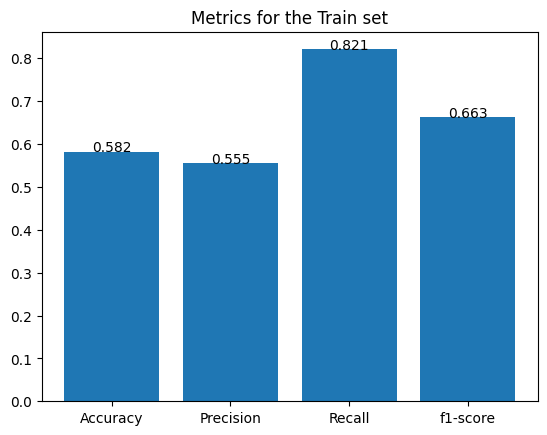

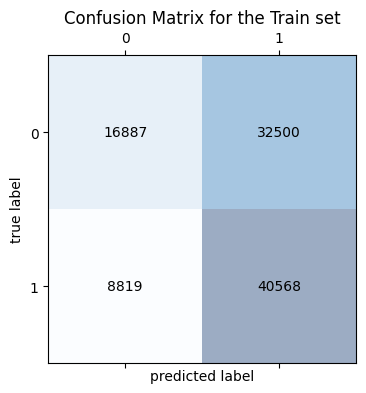

In [28]:
# Train set metrics

aux_functions.show_metrics("Train" ,y_train, y_pred_train)

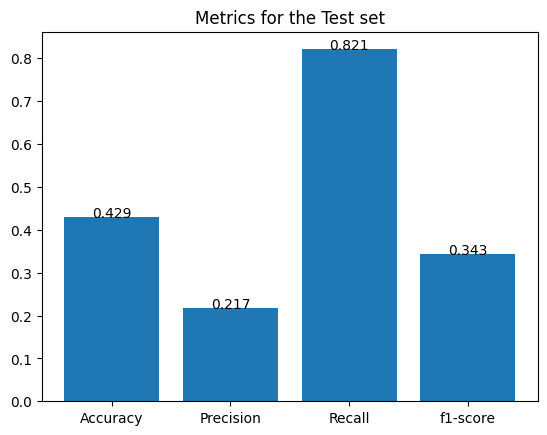

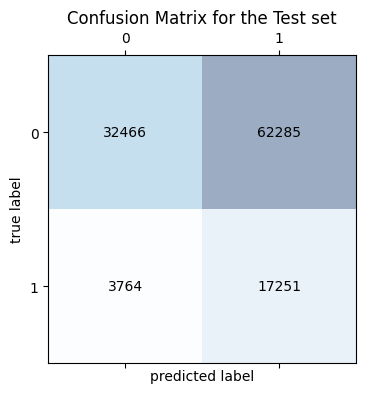

In [29]:
# Test set metrics

aux_functions.show_metrics("Test", y_test, y_pred_test)

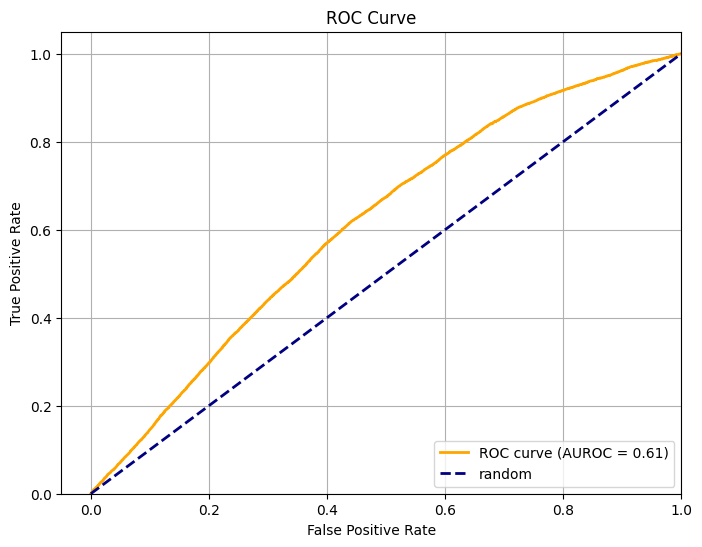

In [30]:
# show roc_curve

aux_functions.plot_roc_curve(y_test, y_proba_test)

Recall requirement: (True, 0.8208898405900548)


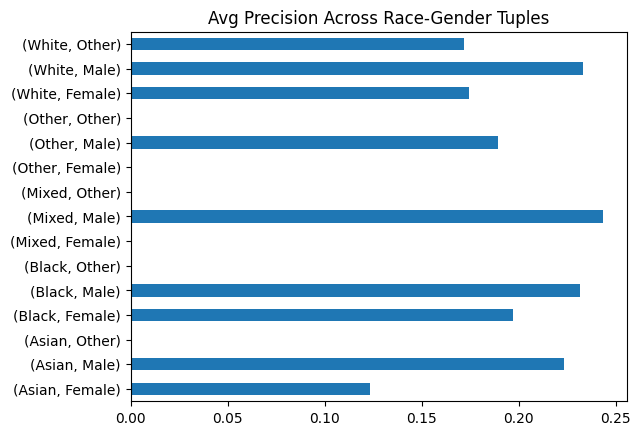

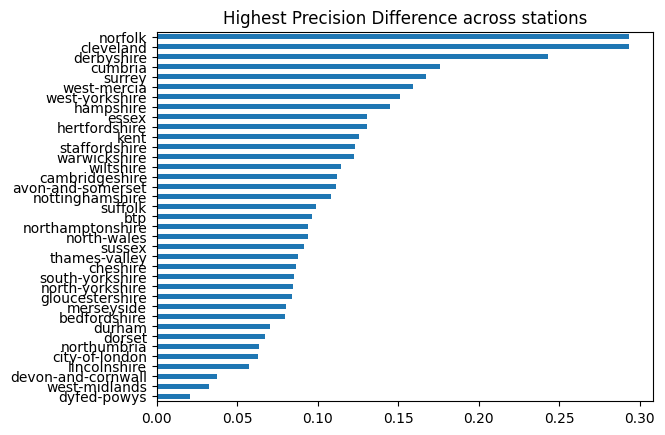

Discrimination requirement
Requirement failed
Global rates: {('White', 'Male'): 0.2330480811451127, ('White', 'Female'): 0.17456437967964242, ('White', 'Other'): 0.17152961980548187, ('Black', 'Male'): 0.2316144040589281, ('Black', 'Female'): 0.19675914533069475, ('Black', 'Other'): nan, ('Asian', 'Male'): 0.22312640411031176, ('Asian', 'Female'): 0.12322894273988666, ('Asian', 'Other'): nan, ('Mixed', 'Male'): 0.2434262027177585, ('Mixed', 'Female'): nan, ('Mixed', 'Other'): nan, ('Other', 'Male'): 0.18930423792049386, ('Other', 'Female'): nan, ('Other', 'Other'): nan}
Num problematic departments: 34
Num good departments: 3
avg diff: 0.11300108108108109


In [31]:
# Check client success rate req

print("Recall requirement: {}".format(aux_functions.verify_success_rate(y_test, y_pred_test, min_success_rate=0.8)))

is_satisfied, problematic_departments, good_deparments, global_precisions, all_departments = aux_functions.verify_no_discrimination_v3(X_test, y_test, y_pred_test)

print("Discrimination requirement")
if not is_satisfied:
    print("Requirement failed")
    print("Global rates: {}".format(global_precisions))
    print("Num problematic departments: {}".format(len(problematic_departments)))
    print("Num good departments: {}".format(len(good_deparments)))
    print("avg diff:", all_departments["diff"].mean())
else:
    print("Requirement satisfied!")

In [32]:
df_result = df_test.copy()
df_result["prediction"] = y_pred_test
df_result

,observation_id,Type,Date,Part of a policing operation,Latitude,Longitude,Gender,Age range,Officer-defined ethnicity,Legislation,Object of search,station,target,prediction
537261,7178a97c-4228-4d89-bbb8-f957b7888823,Person search,2021-08-21T04:20:00+00:00,False,NaN,NaN,Male,25-34,White,Police and Criminal Evidence Act 1984 (section 1),Offensive weapons,south-yorkshire,0,0
696508,2fa0c965-c196-4a2a-bfa3-645b359ca46f,Person search,2020-05-25T17:12:00+00:00,<NA>,50.811679,-1.083062,Male,10-17,Black,Police and Criminal Evidence Act 1984 (section 1),Offensive weapons,hampshire,0,0
109550,4621404c-8b8d-4167-93ea-78a2d95d8195,Person search,2021-02-05T19:22:00+00:00,False,NaN,NaN,Male,18-24,Asian,Misuse of Drugs Act 1971 (section 23),Controlled drugs,devon-and-cornwall,1,1
609848,2b2f6f9d-651e-4d3c-a3a7-a2bc91e721eb,Person search,2020-07-26T13:00:00+00:00,<NA>,53.182283,-3.423552,Male,25-34,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,north-wales,0,1
247836,af52a1fc-66ab-4225-95b3-6f31d236f687,Person search,2020-09-10T23:00:00+00:00,False,50.875152,0.011468,Male,18-24,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,sussex,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
812351,16d89379-a94e-4ef5-a367-9828e9d63da3,Person search,2020-04-19T00:01:00+00:00,False,51.564104,0.504768,Male,10-17,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,essex,0,1
410842,e9f0ce1e-786f-499b-8b0d-f3f3c180848e,Person search,2021-11-15T00:33:00+00:00,False,51.385346,0.542581,Female,25-34,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,kent,0,1
740619,9c360157-1f20-4daa-bc5c-e7353bc4e1bd,Person search,2020-02-01T04:25:00+00:00,<NA>,53.544740,-2.633184,Male,18-24,Black,Police and Criminal Evidence Act 1984 (section 1),Stolen goods,btp,0,0
378117,b934e33c-21c2-4dbc-833e-60ece3391395,Person search,2020-11-07T13:45:00+00:00,<NA>,50.911318,-1.419806,Male,over 34,White,Police and Criminal Evidence Act 1984 (section 1),Stolen goods,hampshire,1,1


In [33]:
total = len(df_result)

model_predictions = len(df_result[df_result["prediction"] == 1])

difference = total - model_predictions

print("The original data had " + str(total) + " searches")

print("With the new model we would have performed " + str(model_predictions) + " searches which is " + str(difference) + " less than the original, or a reduction of " +  str(round((difference / total) * 100, 2)) + " %")

The original data had 115766 searches
With the new model we would have performed 79536 searches which is 36230 less than the original, or a reduction of 31.3 %


In [34]:
original_success = (len(df_result[df_result["target"] == 1]) / len(df_result))

model_success = (len(df_result[(df_result["target"] == 1) & (df_result["prediction"] == 1)]) / len(df_result[(df_result["prediction"] == 1)]))

print("In the original data, the success rate of search operations was " + str(round(original_success,2))) 

print("With the model, the success rate of search operations was " + str(round(model_success,2)))

In the original data, the success rate of search operations was 0.18
With the model, the success rate of search operations was 0.22


In [35]:
missed_cases = len(df_result[(df_result["target"] == 1) & (df_result["prediction"] == 0)])

missed_ratio = missed_cases / len(df_result[(df_result["target"] == 1)])

print("With the model we would have missed " + str(missed_cases) + " which corresponds to " + str(round(missed_ratio * 100, 2)) + " % of all successes in the original data")

With the model we would have missed 3764 which corresponds to 17.91 % of all successes in the original data


In [36]:

    
departments = df_result['station'].unique()
ethnicity_classes = df_result['Officer-defined ethnicity'].unique()
gender_classes = df_result['Gender'].unique()

sensitive_classes = [(x,y) for x in ethnicity_classes for y in gender_classes]

department_rates = {}
for department in departments:
    true_rates = {}
    for sensitive_class in sensitive_classes:

        mask = (df_result['Officer-defined ethnicity'] == sensitive_class[0]) & (df_result['Gender'] == sensitive_class[1]) & (df_result['station'] == department)
        
        total = len(df_result[mask])
        target_true = len(df_result[mask  & (df_result['target'] == 1)])
        target_false = len(df_result[mask  & (df_result['target'] == 0)])

        # client suggests checking discrimination only for race-gender tuples that have a minimum of 30 samples
        if(total < 30):
            true_rate = np.nan 
        else:
            true_rate = target_true / total

        true_rates[sensitive_class] = true_rate
    department_rates[department] = true_rates

rates = pd.DataFrame.from_dict(department_rates).transpose()
rates["diff"] = rates.max(axis=1).round(5) - rates.min(axis=1).round(5)
rates["worst tuple"] = rates.drop(columns=["diff"]).idxmax(axis=1)
rates["best tuple"] = rates.drop(columns=["diff", "worst tuple"]).idxmin(axis=1)
rates

/var/folders/sj/c0wtvkk15b92vcqw5rhy939r0000gn/T/ipykernel_8037/1912556200.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  rates["worst tuple"] = rates.drop(columns=["diff"]).idxmax(axis=1)
/var/folders/sj/c0wtvkk15b92vcqw5rhy939r0000gn/T/ipykernel_8037/1912556200.py:30: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  rates["best tuple"] = rates.drop(columns=["diff", "worst tuple"]).idxmin(axis=1)


White                         Black                  \
                        Male    Female     Other      Male    Female Other   
south-yorkshire     0.092129  0.053476       NaN  0.115517  0.085714   NaN   
hampshire           0.284775  0.250335       NaN  0.254072  0.181818   NaN   
devon-and-cornwall  0.188649  0.176938       NaN  0.185714       NaN   NaN   
north-wales         0.172372  0.123636       NaN       NaN       NaN   NaN   
sussex              0.222776  0.156322       NaN  0.203509       NaN   NaN   
suffolk             0.185019  0.171004       NaN  0.123188       NaN   NaN   
merseyside          0.155789  0.135714       NaN  0.180451       NaN   NaN   
thames-valley       0.183300  0.164760       NaN  0.185500  0.147059   NaN   
kent                0.197655  0.182886       NaN  0.239035  0.218750   NaN   
surrey              0.224162  0.166265       NaN  0.184713  0.157895   NaN   
west-yorkshire      0.167829  0.146199       NaN  0.200988       NaN   NaN   
norfolk             0.120457  0.100279       NaN  0.181208       NaN   NaN   
northumbria         0.213904  0.178082       NaN  0.297872       NaN   NaN   
west-mercia         0.259700  0.226351       NaN  0.353293       NaN   NaN   
hertfordshire       0.209622  0.141667       NaN  0.184496  0.214286   NaN   
staffordshire       0.192226  0.163823  0.133333  0.211640       NaN   NaN   
essex               0.216479  0.132316       NaN  0.256410       NaN   NaN   
cleveland           0.132278  0.147410       NaN  0.018868       NaN   NaN   
avon-and-somerset   0.243949  0.187146       NaN  0.228507       NaN   NaN   
dorset              0.243451  0.198473       NaN  0.258621       NaN   NaN   
nottinghamshire     0.264400  0.168675       NaN  0.221453       NaN   NaN   
btp                 0.186762  0.170418       NaN  0.183983  0.227273   NaN   
cambridgeshire      0.245370  0.164835       NaN  0.282609       NaN   NaN   
cumbria             0.224900  0.090909       NaN       NaN       NaN   NaN   
west-midlands       0.011246  0.017045       NaN  0.015590       NaN   NaN   
gloucestershire     0.198966  0.158730       NaN  0.185185       NaN   NaN   
bedfordshire        0.211706  0.186441       NaN  0.195489       NaN   NaN   
dyfed-powys         0.037424  0.027778       NaN       NaN       NaN   NaN   
wiltshire           0.230892  0.148438       NaN  0.197368       NaN   NaN   
northamptonshire    0.210024  0.177305       NaN  0.223744       NaN   NaN   
cheshire            0.221585  0.222656       NaN  0.263158       NaN   NaN   
lincolnshire        0.057471  0.021622       NaN  0.026667       NaN   NaN   
warwickshire        0.269333  0.204545       NaN  0.264463       NaN   NaN   
city-of-london      0.249158  0.219178       NaN  0.232082       NaN   NaN   
derbyshire          0.194444  0.290323       NaN  0.174419       NaN   NaN   
north-yorkshire     0.211735  0.187097       NaN  0.294118       NaN   NaN   
durham              0.276423  0.203390  0.144928       NaN       NaN   NaN   

                       Asian                     Mixed                  Other  \
                        Male    Female Other      Male Female Other      Male   
south-yorkshire     0.118293  0.097561   NaN       NaN    NaN   NaN  0.098765   
hampshire           0.252492       NaN   NaN       NaN    NaN   NaN  0.296970   
devon-and-cornwall  0.173913       NaN   NaN       NaN    NaN   NaN       NaN   
north-wales              NaN       NaN   NaN       NaN    NaN   NaN  0.092199   
sussex              0.205674       NaN   NaN       NaN    NaN   NaN  0.208333   
suffolk             0.162162       NaN   NaN  0.210000    NaN   NaN  0.146341   
merseyside          0.189744       NaN   NaN       NaN    NaN   NaN  0.195804   
thames-valley       0.157467  0.191489   NaN       NaN    NaN   NaN  0.160000   
kent                0.161826       NaN   NaN  0.235294    NaN   NaN  0.137056   
surrey              0.183391       NaN   NaN       NaN    NaN   NaN       NaN   
west-yor

In [37]:
rates.sort_values(by="diff", ascending=True).to_csv("results/discrimination_rates_model1_test_set.csv")

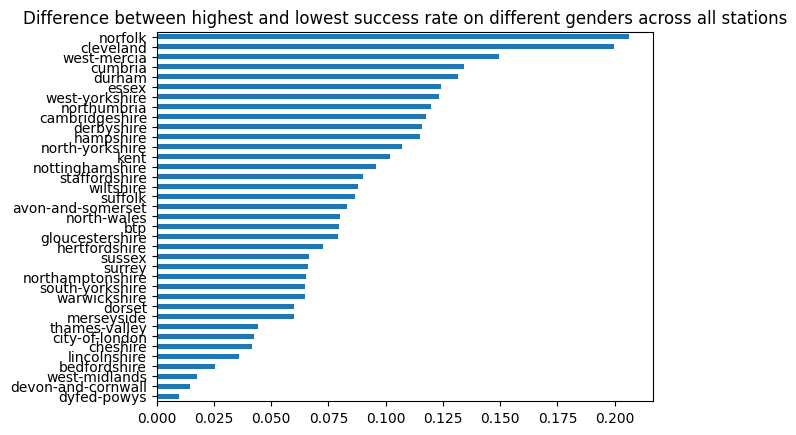

In [38]:
rates.sort_values(by="diff", ascending=True)["diff"].plot.barh()
plt.title("Difference between highest and lowest success rate on different genders across all stations")
plt.show();

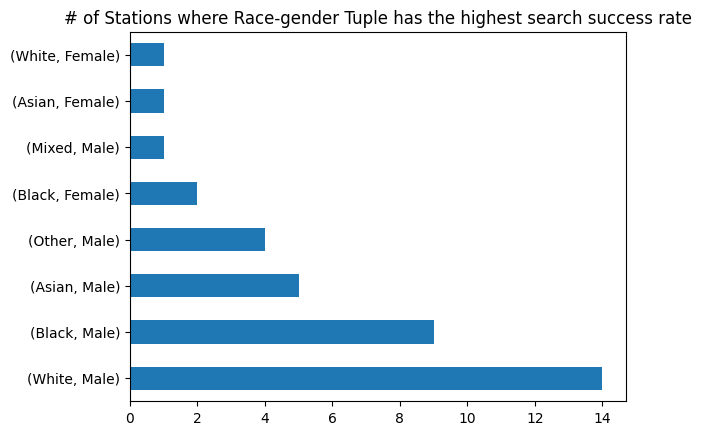

In [39]:
rates["worst tuple"].value_counts().plot.barh()
plt.title("# of Stations where Race-gender Tuple has the highest search success rate")
plt.show();

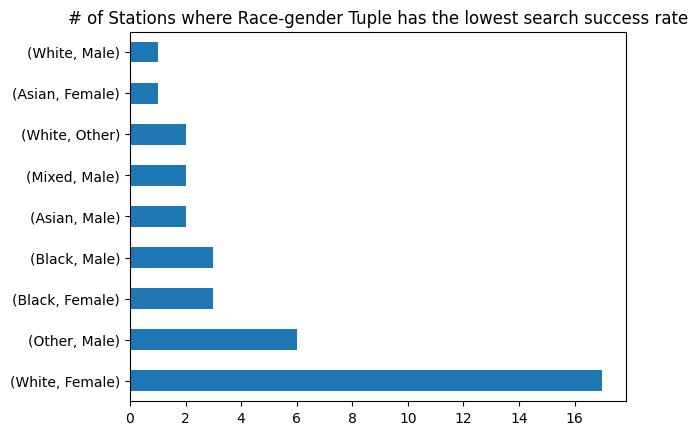

In [40]:
rates["best tuple"].value_counts().plot.barh()
plt.title("# of Stations where Race-gender Tuple has the lowest search success rate")
plt.show();

In [41]:

    
departments = df_result['station'].unique()
ethnicity_classes = df_result['Officer-defined ethnicity'].unique()
gender_classes = df_result['Gender'].unique()

sensitive_classes = [(x,y) for x in ethnicity_classes for y in gender_classes]

department_rates = {}
for department in departments:
    true_rates = {}
    for sensitive_class in sensitive_classes:

        mask = (df_result['Officer-defined ethnicity'] == sensitive_class[0]) & (df_result['Gender'] == sensitive_class[1]) & (df_result['station'] == department)
        
        total = len(df_result[mask])
        target_true = len(df_result[mask  & (df_result['prediction'] == 1)])
        target_false = len(df_result[mask  & (df_result['prediction'] == 0)])

        # client suggests checking discrimination only for race-gender tuples that have a minimum of 30 samples
        if(total < 30):
            true_rate = np.nan 
        else:
            true_rate = target_true / total

        true_rates[sensitive_class] = true_rate
    department_rates[department] = true_rates

rates = pd.DataFrame.from_dict(department_rates).transpose()
rates["diff"] = rates.max(axis=1).round(5) - rates.min(axis=1).round(5)
rates["worst tuple"] = rates.drop(columns=["diff"]).idxmax(axis=1)
rates["best tuple"] = rates.drop(columns=["diff", "worst tuple"]).idxmin(axis=1)
rates

/var/folders/sj/c0wtvkk15b92vcqw5rhy939r0000gn/T/ipykernel_8037/773424507.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  rates["worst tuple"] = rates.drop(columns=["diff"]).idxmax(axis=1)
/var/folders/sj/c0wtvkk15b92vcqw5rhy939r0000gn/T/ipykernel_8037/773424507.py:30: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  rates["best tuple"] = rates.drop(columns=["diff", "worst tuple"]).idxmin(axis=1)


White                         Black                  \
                        Male    Female     Other      Male    Female Other   
south-yorkshire     0.564190  0.572193       NaN  0.665517  0.542857   NaN   
hampshire           0.783678  0.890228       NaN  0.863192  0.878788   NaN   
devon-and-cornwall  0.815348  0.848907       NaN  0.871429       NaN   NaN   
north-wales         0.505105  0.556364       NaN       NaN       NaN   NaN   
sussex              0.623026  0.689655       NaN  0.740351       NaN   NaN   
suffolk             0.771536  0.825279       NaN  0.833333       NaN   NaN   
merseyside          0.665690  0.706122       NaN  0.659148       NaN   NaN   
thames-valley       0.745129  0.838673       NaN  0.766166  0.784314   NaN   
kent                0.759911  0.798658       NaN  0.800439  0.843750   NaN   
surrey              0.550260  0.600000       NaN  0.601911  0.473684   NaN   
west-yorkshire      0.542331  0.588694       NaN  0.589786       NaN   NaN   
norfolk             0.736760  0.818942       NaN  0.684564       NaN   NaN   
northumbria         0.528877  0.547945       NaN  0.617021       NaN   NaN   
west-mercia         0.628039  0.692568       NaN  0.688623       NaN   NaN   
hertfordshire       0.629630  0.741667       NaN  0.717829  0.690476   NaN   
staffordshire       0.678914  0.740614  0.644444  0.708995       NaN   NaN   
essex               0.748315  0.798982       NaN  0.794872       NaN   NaN   
cleveland           0.482125  0.585657       NaN  0.471698       NaN   NaN   
avon-and-somerset   0.687668  0.769376       NaN  0.805430       NaN   NaN   
dorset              0.708783  0.885496       NaN  0.793103       NaN   NaN   
nottinghamshire     0.817488  0.783133       NaN  0.768166       NaN   NaN   
btp                 0.794282  0.797428       NaN  0.748918  0.893939   NaN   
cambridgeshire      0.655864  0.659341       NaN  0.728261       NaN   NaN   
cumbria             0.417671  0.454545       NaN       NaN       NaN   NaN   
west-midlands       0.492034  0.590909       NaN  0.476615       NaN   NaN   
gloucestershire     0.731266  0.769841       NaN  0.814815       NaN   NaN   
bedfordshire        0.748443  0.855932       NaN  0.823308       NaN   NaN   
dyfed-powys         0.518712  0.569444       NaN       NaN       NaN   NaN   
wiltshire           0.773885  0.906250       NaN  0.750000       NaN   NaN   
northamptonshire    0.680191  0.709220       NaN  0.703196       NaN   NaN   
cheshire            0.656638  0.722656       NaN  0.705263       NaN   NaN   
lincolnshire        0.645320  0.718919       NaN  0.746667       NaN   NaN   
warwickshire        0.649333  0.780303       NaN  0.743802       NaN   NaN   
city-of-london      0.654882  0.780822       NaN  0.696246       NaN   NaN   
derbyshire          0.576797  0.731183       NaN  0.686047       NaN   NaN   
north-yorkshire     0.716837  0.761290       NaN  0.794118       NaN   NaN   
durham              0.509872  0.618644  0.565217       NaN       NaN   NaN   

                       Asian                     Mixed                  Other  \
                        Male    Female Other      Male Female Other      Male   
south-yorkshire     0.702439  0.682927   NaN       NaN    NaN   NaN  0.703704   
hampshire           0.877076       NaN   NaN       NaN    NaN   NaN  0.775758   
devon-and-cornwall  0.891304       NaN   NaN       NaN    NaN   NaN       NaN   
north-wales              NaN       NaN   NaN       NaN    NaN   NaN  0.489362   
sussex              0.787234       NaN   NaN       NaN    NaN   NaN  0.875000   
suffolk             0.864865       NaN   NaN  0.770000    NaN   NaN  0.756098   
merseyside          0.589744       NaN   NaN       NaN    NaN   NaN  0.629371   
thames-valley       0.814062  0.914894   NaN       NaN    NaN   NaN  0.640000   
kent                0.788382       NaN   NaN  0.759358    NaN   NaN  0.751269   
surrey              0.640138       NaN   NaN       NaN    NaN   NaN       NaN   
west-yor

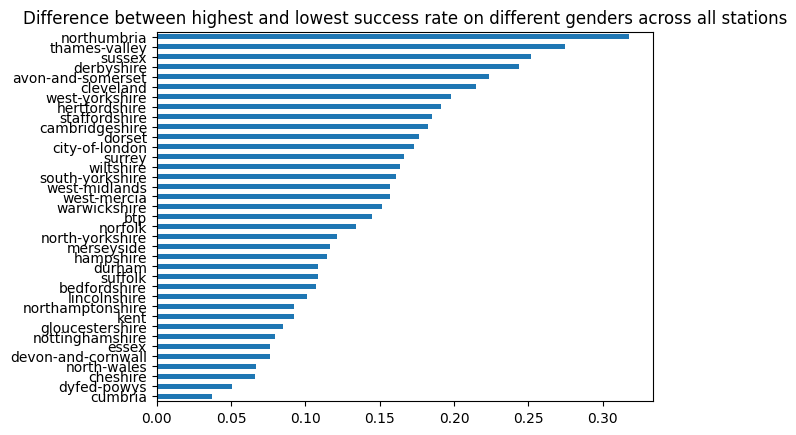

In [42]:
rates.sort_values(by="diff", ascending=True)["diff"].plot.barh()
plt.title("Difference between highest and lowest success rate on different genders across all stations")
plt.show();

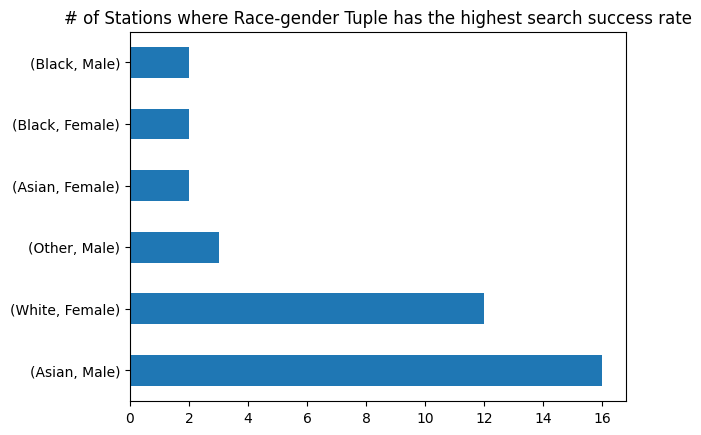

In [43]:
rates["worst tuple"].value_counts().plot.barh()
plt.title("# of Stations where Race-gender Tuple has the highest search success rate")
plt.show();

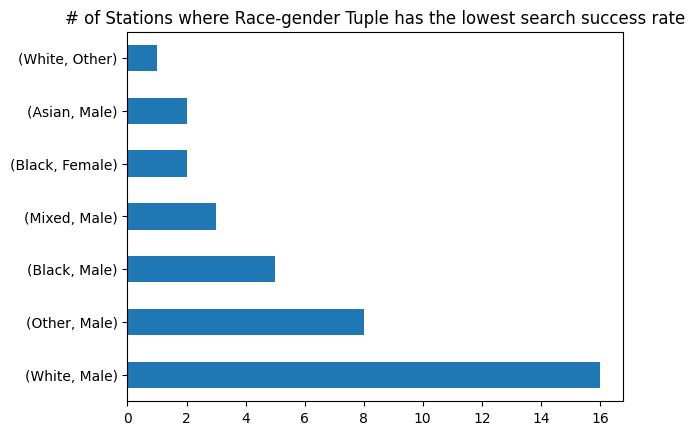

In [44]:
rates["best tuple"].value_counts().plot.barh()
plt.title("# of Stations where Race-gender Tuple has the lowest search success rate")
plt.show();